In [1]:
import numpy as np
%matplotlib inline
import healpy as hp
from lsst.sims.utils import healbin

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [11]:
# generate some fake stars. Not uniformly distributed on sphere.
nstars = 10000
ra = np.random.rand(nstars)*360
dec = np.random.rand(nstars)*180.-90
mags = np.random.rand(nstars)*20

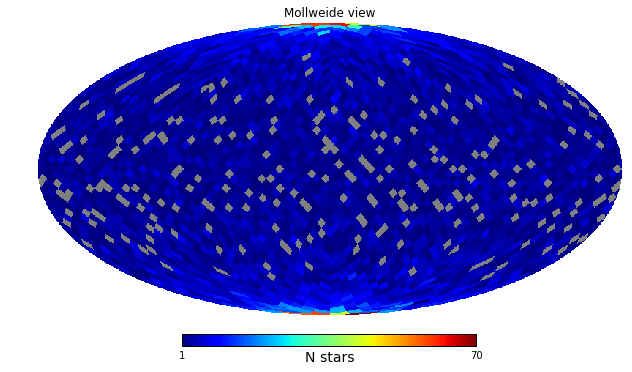

In [12]:
# Count the number of stars
starmap = healbin(ra,dec,ra,nside=16, reduceFunc=np.size)
hp.mollview(starmap, unit='N stars')

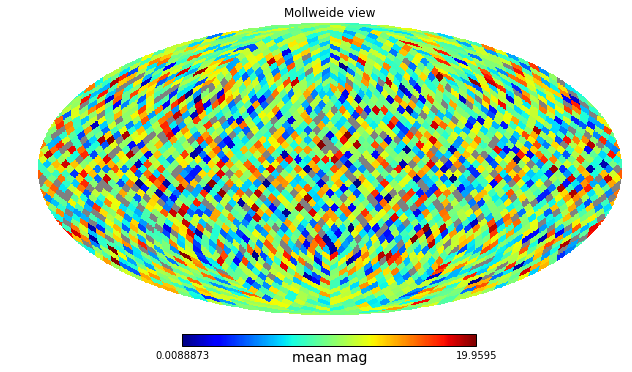

In [13]:
# find the average mag in each bin
starmap = healbin(ra,dec,mags, nside=16, reduceFunc=np.mean)
hp.mollview(starmap, unit='mean mag')

In [14]:
help(healbin)

Help on function healbin in module lsst.sims.utils.healpyUtils:

healbin(ra, dec, values, nside=128, reduceFunc=<function mean>, dtype=<type 'float'>)
    Take arrays of ra's, dec's, and value and bin into healpixels. Like numpy.hexbin but for
    bins on a sphere.
    
    Parameters
    ----------
    ra : np.array
        RA positions of the data points. Degrees.
    dec : np.array
        Dec positions of the data points. Degrees.
    values : np.array
        The values at each ra,dec position.
    nside : int
        Healpixel nside resolution. Must be a value of 2^N.
    reduceFunc : function (numpy.mean)
        A function that will return a single value given a subset of `values`.
    dtype : dtype ('float')
        Data type of the resulting mask
    
    Returns
    -------
    mapVals : np.array
        A numpy array that is a valid Healpixel map.

